# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import mlflow

from sklearn import metrics as metrics_sklearn

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Méthodes

### Méthodes pour les datas

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [4]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [5]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [7]:
def clean_text(X):
    X = X.split()
    X_wo_arobas = [x for x in X if not x.startswith("@")]
    X_new = [x for x in X_wo_arobas if not x.startswith("http")]
    return ' '.join(X_new)

In [8]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [9]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [10]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [11]:
def clean_textism(sentence):
    neo_sentence = []
    for word in sentence:
        if word == 'u':
            neo_sentence.append('you')
        elif word == 'r':
            neo_sentence.append('are')
        elif word == 'ur':
            neo_sentence.append('your')
        elif word == 'some1':
            neo_sentence.append('someone')
        elif word == 'yrs':
            neo_sentence.append('years')
        elif word == 'hrs':
            neo_sentence.append('hours')
        elif word == 'mins':
            neo_sentence.append('minutes')
        elif word == 'secs':
            neo_sentence.append('seconds')
        elif word == 'pls' or word == 'plz':
            neo_sentence.append('please')
        elif word == '2morow':
            neo_sentence.append('tomorrow')
        elif word == '2day':
            neo_sentence.append('today')
        elif word == '2nite':
            neo_sentence.append('tonight')
        elif word == '4got' or word == '4gotten':
            neo_sentence.append('forget')
        elif word == 'amp' or word == 'quot' or word == 'lt' or word == 'gt' or word == '½25':
            neo_sentence.append('')
        else:
            neo_sentence.append(word)
    return neo_sentence

In [12]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():        
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        tk = tokenize.TweetTokenizer(reduce_len=True)
        temp_res = tk.tokenize(temp_res)
        
        # clean the sms language to usefull langage
        temp_res = clean_textism(temp_res)
        
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
        else:
            print("stem or lemma only")
            
        result.append(temp_res)
    return result

In [13]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # supprimer des mots spécifiques à twitter (commençant par @ et hhtp)
    df[col] = df[col].apply(clean_text)
    
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

### Méthodes pour BOW and Word Embedding

In [14]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [15]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
def representation_by_doc2vec(corpus):
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]
    return X

### Méthodes pour les métriques

In [16]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None, specifity=False):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics_sklearn.confusion_matrix(actual_class, predict_class)#, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    displ = metrics_sklearn.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()
    
    # compute specificity
    if specifity:
        speci = cm[0, 0]/(cm[0, 0] + cm[1, 0])
        print("Spécificité :", speci)
        return speci
    
    return False

In [17]:
def plot_roc_curve(model_name, y_test, y_test_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics_sklearn.roc_curve(y_test, y_test_pred)#, pos_label=1)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [18]:
def display_classification_metrics(estimator, X_test, y_test, y_test_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    print("Calcul et affichage des différentes métriques")
    result = {}
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics_sklearn.accuracy_score(y_test, y_test_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics_sklearn.precision_score(y_test, y_test_pred, average='macro').round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics_sklearn.recall_score(y_test, y_test_pred, average='macro').round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics_sklearn.roc_auc_score(y_test, y_test_pred, average='macro').round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(type(estimator).__name__, y_test, y_test_pred)
        elif met == "f1":   
            te_res = metrics_sklearn.f1_score(y_test, y_test_pred, average='macro').round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics_sklearn.fbeta_score(y_test, y_test_pred, beta=beta, average='macro').round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)
        else:
            print("La métrique", met, "n'est pas dans la liste suivante accuracy, recall, precision, auc, f1 et fbeta. Veuillez vérifier la saisie.")
        result[met] = te_res
    return result

### Méthodes pour les modèles de régression

In [19]:
from sklearn import naive_bayes
def get_naive_bayes_model(model_name="gaussian"):
    """return an instance of the model selected
    
    Parameters:
    model_name (str) : names of naive bayes model used
    
    Returns:
    instance of the model
    """
    if model_name == "gaussian":
        return naive_bayes.GaussianNB()
    elif model_name == "multinomial":
        return naive_bayes.MultinomialNB()
    elif model_name == "bernoulli":
        return naive_bayes.BernoulliNB()
    else:
        return -1

### Méthodes pour les Réseaux de neurones

In [20]:
from keras.preprocessing import text
def tokenize_corpus(corpus):
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

2023-07-26 15:53:18.700097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 15:53:18.770542: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 15:53:19.133757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-26 15:53:19.133797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [21]:
from gensim import models
def word_embedding_by_word2vec(embed_dim, data):
    w2v_model = models.word2vec.Word2Vec(data, vector_size=embed_dim, workers=8)
    # w2v_model.build_vocab(data)
    w2v_model.train(data, total_examples=len(data), epochs=50)
    return w2v_model

In [22]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip data/glove.twitter.27B.zip
def word_embedding_by_glove(corpus):
    GLOVE_EMB = 'glove.twitter.27B.200d.txt'
      
    # compute embeddings index from GloVe
    embeddings_index = {}
    f = open(GLOVE_EMB)
    for line in f:
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' %len(embeddings_index))
    return embeddings_index   

In [23]:
def compute_corpus_to_word_embedding(corpus, model_name="word2vec"):
    tokenizer = tokenize_corpus(corpus)
    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1  
    
    if model_name == "word2vec":
        embed_dim = 800
        
        # word embedding using Word2Vec
        w2v_model = word_embedding_by_word2vec(embed_dim, corpus)
        word_index = w2v_model.wv.key_to_index
        # vocab_size = len(word_index)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in tokenizer.word_index.items():
            if w2v_model.wv.__contains__(word):
                embedding_matrix[i] = w2v_model.wv.__getitem__(word)
    elif model_name == "glove":
        embed_dim = 200
        
        # word embedding using GloVe
        embeddings_index = word_embedding_by_glove(corpus)
        
        # compute embedding matrix
        embedding_matrix = np.zeros((vocab_size, embed_dim))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    print("Embedding Matrix Shape:", embedding_matrix.shape)
    return embedding_matrix, tokenizer, embed_dim

In [24]:
import keras.backend as K
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [25]:
def display_result_plot(history):
    spec,  val_spec  = history.history['specificity'], history.history['val_specificity']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training spec')
    plt.plot(epochs, val_spec, 'r', label='Validation spec')
    plt.title('Training and validation specificity')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [26]:
def create_neural_network_model(embedding_layer):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [27]:
def train_neural_network_model(model, X_train, y_train, X_test, y_test):
    # on crée les méthodes de callback permettant d'arrêter l'entraînement dès que certaines conditions sont remplies
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=10, cooldown=0),
        EarlyStopping(monitor='val_specificity', min_delta=1e-4, patience=10)
    ]
 
    history = model.fit(X_train, y_train, batch_size=1024, epochs=20,
                        validation_data=(X_test, y_test), callbacks=callbacks,
                        verbose=1)
    
    return history

# Preparing dataset

In [28]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", sep=',',
                   encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [29]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [30]:
data["target"].replace(4, 1, inplace=True)

,%,%_cumul
label,,
0,50.0,50.0
1,50.0,100.0


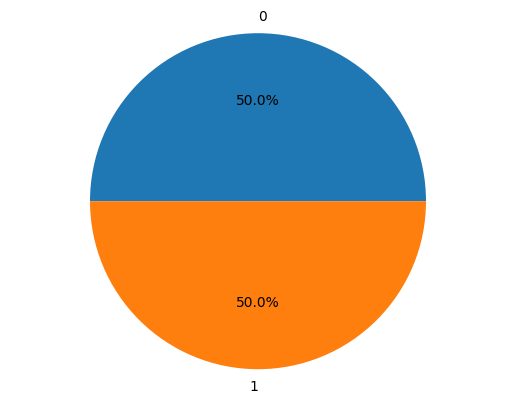

,%,%_cumul
label,,
0,50.0,50.0


In [31]:
show_unique_values(data, "target")

Sentiment du tweet 0 pour négatif et 4 pour positif  
Dans tous les cas, nous n'avons besoin que du texte du tweet et de la target

In [32]:
data.drop(columns=["id", "date", "flag", "user"], inplace=True)

In [33]:
print("The dataset is containing", data.shape[0], "lines and", data.shape[1], "columns.")

The dataset is containing 1600000 lines and 2 columns.


On commence par prendre un échantillon des données dans un premier temps : 10 000 de chaque target.

In [34]:
data_words = data.groupby(['target']).apply(pd.DataFrame.sample, n=10000, replace=True, random_state=42).reset_index(drop=True)

In [35]:
print("The sample dataset is containing", data_words.shape[0], "lines and", data_words.shape[1], "columns.")

The sample dataset is containing 20000 lines and 2 columns.


# Preprocessing

Il y a un total de 9137 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 0 fois et moins de 999 fois. Il reste alors 9133 mots différents dans tout le corpus.



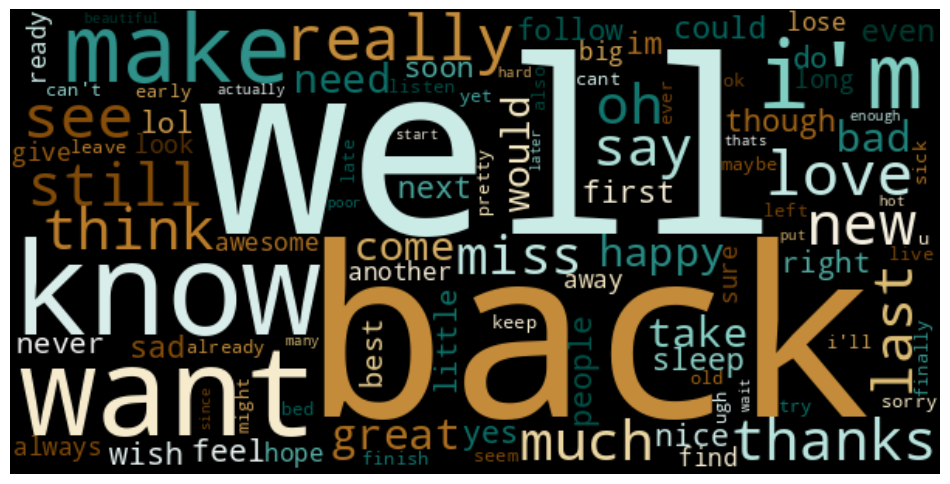

In [36]:
words_to_exclude = [
    "...", ".."
]
tags_to_remove=["NNP", "NN", "VBG", "VBN", "CD"]

corpus = natural_language_processing(
    data_words, "text", stem_or_lemma="lemma", debug=False, word_cloud=True,
    tags_to_remove=tags_to_remove, words_to_exclude=words_to_exclude)

In [37]:
data_words.head()

,filtexcl_words,filtpos_text,preproc_text,target,text
0,"[go, fail]","[go, fail]","[home, study, math, wooot, im, go, fail, shit]",0,home studying for maths wooot ! im so going to...
1,"[odeee, miss, table, bout]","[..., odeee, miss, table, ..., bout, ...]","[pickin, waitin, 2, hurry, ..., odeee, miss, d...",0,Pickin up waitin on 2 hurry up...I odeeee miss...
2,"[rather, average]","[rather, average]","[rather, average, 32370]",0,I rather average 32370
3,"[i'm, try, reach, seem, impossible]","[i'm, try, reach, seem, impossible]","[i'm, try, reach, dream, seem, impossible, adv...",0,"I'm trying to reach my dreams, but it seems im..."
4,"[middle, want]","[middle, want, ...]","[song's, middle, change, want, born, ..., arghhh]",0,this song's middle change just doesn't want to...


In [38]:
# drop des colonnes inutiles
data_words.drop(columns=["filtpos_text", "preproc_text", "text"], inplace=True)

In [39]:
def join_back(text):
    return ' '.join(text)

data_words['sentence'] = data_words['filtexcl_words'].apply(join_back)
data_words.rename(columns={"filtexcl_words": "list_words"}, inplace=True)

In [40]:
data_words.head()

,list_words,target,sentence
0,"[go, fail]",0,go fail
1,"[odeee, miss, table, bout]",0,odeee miss table bout
2,"[rather, average]",0,rather average
3,"[i'm, try, reach, seem, impossible]",0,i'm try reach seem impossible
4,"[middle, want]",0,middle want


# Approche modèles sur mesure simple

Utilisation du bag of words pour le test des modèles sur mesure simple

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=800)# vectorizing words and storing in variable X(predictor)
X = cv.fit_transform(data_words["sentence"]).toarray()
print(X.shape)
y = data_words.target.values# y size
print(y.shape)

(20000, 800)
(20000,)


In [42]:
# 3 parties : train 60%, validation 20% and test 20%
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

### Test des 3 Naive Bayes models

In [43]:
for nb_model in ["gaussian", "multinomial", "bernoulli"]:
    model = get_naive_bayes_model(nb_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = display_classification_metrics(model, X_test, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False)

Calcul et affichage des différentes métriques
Précision : 0.638
AUC : 0.599
Calcul et affichage des différentes métriques
Précision : 0.647
AUC : 0.642
Calcul et affichage des différentes métriques
Précision : 0.662
AUC : 0.659


Bernoulli est meilleur comme model de référence

### Test avec Naive Bayes Bernoulli

Calcul et affichage des différentes métriques
Précision : 0.667
AUC : 0.664
Calcul et affichage de la courbe ROC


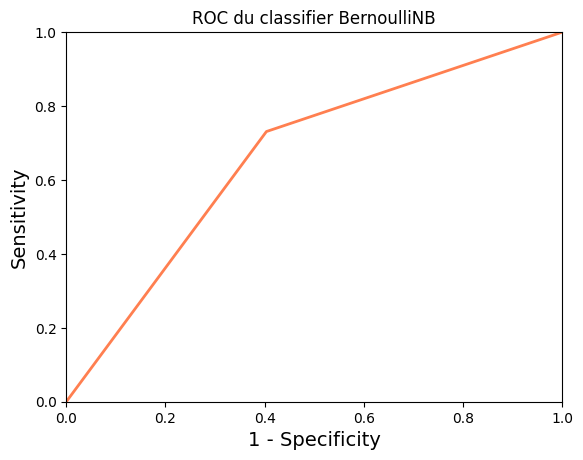

In [44]:
model = get_naive_bayes_model("bernoulli")
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
res = display_classification_metrics(model, X_val, y_val, y_pred, list_metrics=["precision", "auc"], roc_curve=True)

Calcul et affichage de la matrice de confusion


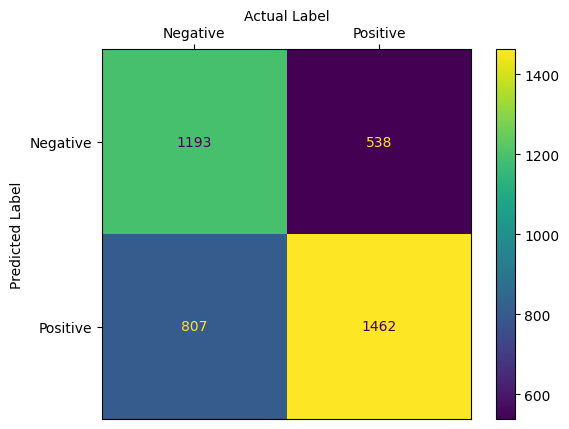

Spécificité : 0.5965


In [45]:
speci_bayes = display_confusion_matrix(actual_class=y_val, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)

### Test avec XGBoost

In [46]:
from sklearn import ensemble

Calcul et affichage des différentes métriques
Précision : 0.667
AUC : 0.664
Calcul et affichage de la courbe ROC


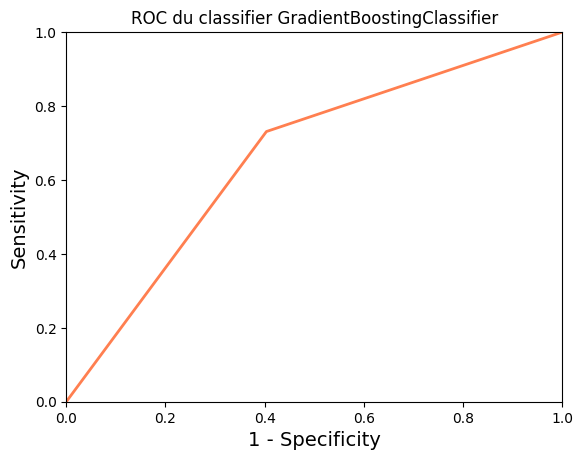

In [47]:
model_xgb = ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_val)
res_xgb = display_classification_metrics(model_xgb, X_val, y_val, y_pred, list_metrics=["precision", "auc"], roc_curve=True)

Calcul et affichage de la matrice de confusion


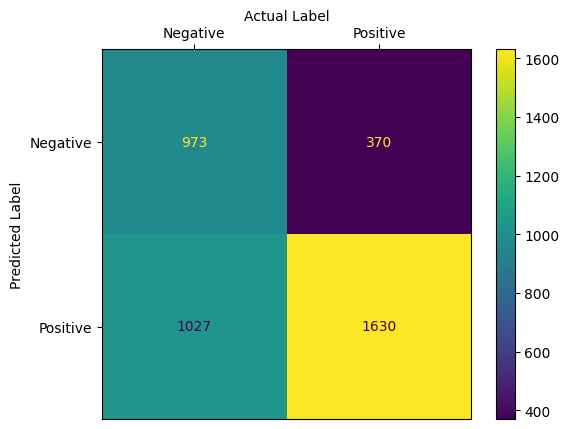

Spécificité : 0.4865


In [48]:
speci_xgboost = display_confusion_matrix(actual_class=y_val, predict_class=y_pred_xgb, display_labels=["Negative", "Positive"], specifity=True)

# ML

### Splitting data

In [49]:
from sklearn import model_selection

In [50]:
# 3 parties : train 60%, validation 20% and test 20%
X, y = np.array(data_words['sentence']), np.array(data_words['target'])

X_train, X_temp, y_train, y_temp = model_selection.train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

In [51]:
print("Train data shape :", X_train.shape)
print("Test data shape :", X_test.shape)
print("Validation data shape :", X_val.shape)

Train data shape : (12000,)
Test data shape : (4000,)
Validation data shape : (4000,)


## Word Embedding

In [52]:
# corpus = list of documents
corpus = data_words["list_words"].tolist()

In [53]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, losses, optimizers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [54]:
MAX_SENTENCE_LENGTH = 280 # max characters in a tweet

In [55]:
tokenizer = tokenize_corpus(corpus)
    
X_train = sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SENTENCE_LENGTH)
X_test  = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=MAX_SENTENCE_LENGTH)
X_val  = sequence.pad_sequences(tokenizer.texts_to_sequences(X_val) , maxlen=MAX_SENTENCE_LENGTH)

On teste les word embedding Word2Vec et GloVe. Chacun a des paramètres différents.

In [56]:
truc = bidule

NameError: name 'bidule' is not defined

### Simple neural network

In [68]:
speci_res = {}

for word_embed_model in ["word2vec", "glove"]:
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_neural_network_model(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model(model, X_train, y_train, X_test, y_test)
    
    # show the result into a graph
    display_result_plot(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    speci = display_confusion_matrix(actual_class=y_val, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    speci_res[word_embed_model] = speci

---------------------------------------------------------------------- Embedding model word2vec ----------------------------------------------------------------------
Embedding Matrix Shape: (9138, 800)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 280, 800)          7310400   
                                                                 
 conv1d_3 (Conv1D)           (None, 276, 128)          512128    
                                                                 
 flatten_1 (Flatten)         (None, 35328)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                565264    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                 


KeyboardInterrupt



In [ ]:
speci_res

## LSTM

In [57]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
def create_lstm_neural_network_model(embedding_layer):
    # on crée la séquence avec toutes les couches de notre réseau de neurones
    model = keras.Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=True)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [ ]:
speci_res = {}

for word_embed_model in ["word2vec", "glove"]:
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_lstm_neural_network_model(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model(model, X_train, y_train, X_test, y_test)
    
    # show the result into a graph
    display_result_plot(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    speci = display_confusion_matrix(actual_class=y_val, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    speci_res[word_embed_model] = speci

In [ ]:
speci_res

## GRU

In [58]:
from tensorflow.keras.layers import GRU

In [69]:
def create_gru_neural_network_model(embedding_layer):
    # instance de neural network model
    model = keras.Sequential()
    
    # on ajoute toutes les couches nécessaires
    model.add(embedding_layer)
    model.add(layers.Conv1D(128, 5, activation='relu'))
    # model.add(layers.Flatten())
    model.add(layers.GRU(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    # on crée les fonctions de loss et d'optimisation
    loss = losses.BinaryCrossentropy(from_logits=False)
    optimizer = optimizers.Adam(learning_rate=2e-4, epsilon=1e-08)
    
    # on compile le modèle
    model.compile(loss=loss, optimizer=optimizer, metrics=[specificity])
    model.summary()
    
    return model

In [70]:
speci_res = {}

for word_embed_model in ["word2vec", "glove"]:
    print("-"*70, "Embedding model", word_embed_model, "-"*70)
    
    # word embedding
    embed_mat, tokenizer, embed_dim = compute_corpus_to_word_embedding(corpus, model_name=word_embed_model)
    vocab_size = len(tokenizer.word_index) + 1
    
    # create embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim, weights=[embed_mat],
        input_length=MAX_SENTENCE_LENGTH, trainable=False)
    
    # create the neural network
    model = create_gru_neural_network_model(embedding_layer)
    
    # train the neural network
    history = train_neural_network_model(model, X_train, y_train, X_test, y_test)
    
    # show the result into a graph
    display_result_plot(history)
    
    # compute confusion matrix and specificity
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred>=0.5, 1, 0)
    speci = display_confusion_matrix(actual_class=y_val, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)
    speci_res[word_embed_model] = speci

---------------------------------------------------------------------- Embedding model word2vec ----------------------------------------------------------------------


AttributeError: module 'transformers.models' has no attribute 'word2vec'

In [71]:
speci_res

{'word2vec': 0.902, 'glove': 0.7045}

# BERT

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 474774558074592344
xla_global_id: -1
]


In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))

[]


In [8]:
import torch
torch.cuda.is_available()

False

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [72]:
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [73]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

loading file vocab.txt from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/tokenizer_config.json
loading configuration file config.json from cache at /home/slerendu/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

In [ ]:
# for sent in data_words["sentence"]:
#     tokens=bert_tokenizer.tokenize(sent)

In [74]:
input_ids=[]
attention_masks=[]

for sent in data_words["sentence"]:
    bert_inp = bert_tokenizer.encode_plus(
        sent, add_special_tokens=True, max_length=64, pad_to_max_length=True,
        return_attention_mask=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(data_words['target'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [75]:
len(input_ids), len(attention_masks), len(labels)

(20000, 20000, 20000)

In [76]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# callbacks = [tf.keras.callbacks.ModelCheckpoint(
#     filepath=model_save_path,save_weights_only=True,monitor='val_loss',
#     mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

In [90]:
import tensorflow as tf

In [91]:
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
# learning_rate=2e-5 recommended by the Bert team

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [92]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

In [93]:
history=bert_model.fit(
    [train_inp,train_mask],train_label,batch_size=32,epochs=4,
    validation_data=([val_inp,val_mask],val_label))

Epoch 1/4


2023-07-26 18:05:47.479786: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


500/500 [==============================] - ETA: 0s - loss: 0.3827 - categorical_accuracy: 0.4841

2023-07-26 18:24:48.170215: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node tf_bert_for_sequence_classification/bert/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


500/500 [==============================] - 1229s 2s/step - loss: 0.3827 - categorical_accuracy: 0.4841 - val_loss: 0.3362 - val_categorical_accuracy: 0.4730
Epoch 2/4
500/500 [==============================] - 1215s 2s/step - loss: 0.2982 - categorical_accuracy: 0.4751 - val_loss: 0.3670 - val_categorical_accuracy: 0.4672
Epoch 3/4
500/500 [==============================] - 1221s 2s/step - loss: 0.2413 - categorical_accuracy: 0.4866 - val_loss: 0.4073 - val_categorical_accuracy: 0.4518
Epoch 4/4
500/500 [==============================] - 1217s 2s/step - loss: 0.2136 - categorical_accuracy: 0.4734 - val_loss: 0.4337 - val_categorical_accuracy: 0.5598


In [95]:
def display_result_plot_accuracy(history):
    spec,  val_spec  = history.history['categorical_accuracy'], history.history['val_categorical_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(len(spec))

    plt.plot(epochs, spec, 'b', label='Training spec')
    plt.plot(epochs, val_spec, 'r', label='Validation spec')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

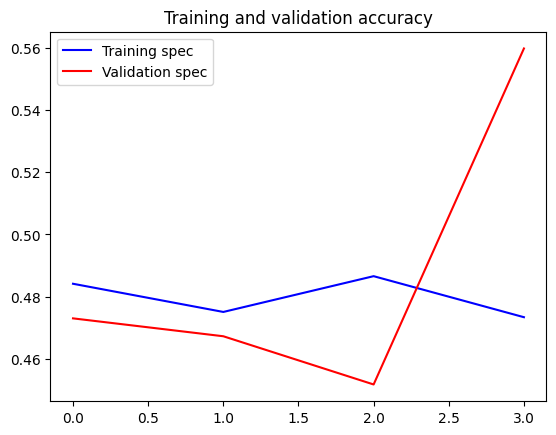

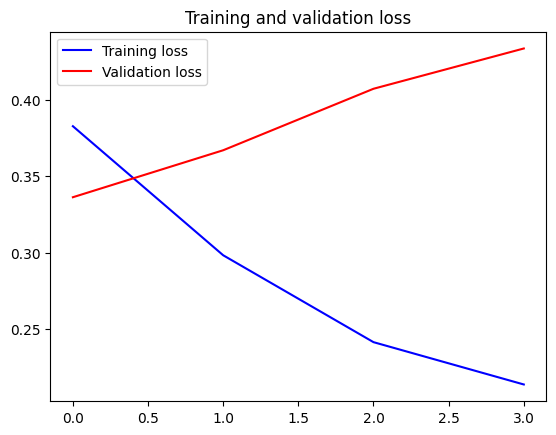

In [96]:
display_result_plot_accuracy(history)

In [97]:
# compute confusion matrix and specificity
y_pred = bert_model.predict(X_val)

125/125 [==============================] - 488s 4s/step


In [98]:
y_pred

TFSequenceClassifierOutput(loss=None, logits=array([[-2.7623954,  2.1265492],
       [-2.7540784,  2.1160793],
       [-2.7536292,  2.115446 ],
       ...,
       [-2.75752  ,  2.1203532],
       [-2.7593668,  2.1225522],
       [-2.7572467,  2.1202183]], dtype=float32), hidden_states=None, attentions=None)

In [99]:
pred_labels = y_pred["logits"].argmax(axis=1)

In [100]:
pred_labels

array([1, 1, 1, ..., 1, 1, 1])

In [101]:
pred_res = []
for tup in y_pred["logits"]:
    if tup[1]>=0.5:
        pred_res.append(1)
    else:
        pred_res.append(0)

Calcul et affichage de la matrice de confusion


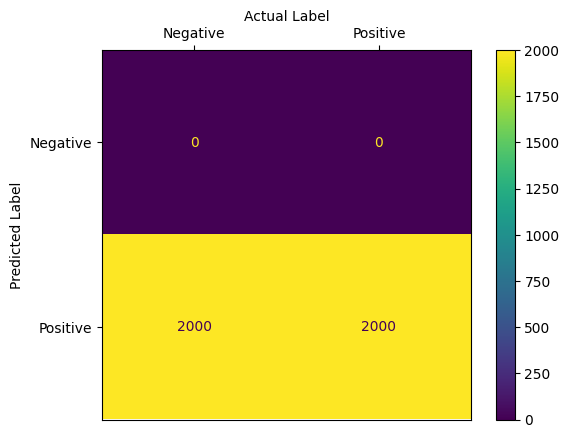

Spécificité : 0.0


In [102]:
speci = display_confusion_matrix(actual_class=y_val, predict_class=pred_labels, display_labels=["Negative", "Positive"], specifity=True)